Epoch [200/2000], Train Loss: 0.000193, Val Loss: 0.000399
Epoch [400/2000], Train Loss: 0.000042, Val Loss: 0.000072
Epoch [600/2000], Train Loss: 0.000042, Val Loss: 0.000077
Epoch [800/2000], Train Loss: 0.000017, Val Loss: 0.000018
Epoch [1000/2000], Train Loss: 0.000030, Val Loss: 0.000034
Epoch [1200/2000], Train Loss: 0.000197, Val Loss: 0.000069
Epoch [1400/2000], Train Loss: 0.000008, Val Loss: 0.000014
Epoch [1600/2000], Train Loss: 0.000006, Val Loss: 0.000008
Epoch [1800/2000], Train Loss: 0.000007, Val Loss: 0.000010
Epoch [2000/2000], Train Loss: 0.000032, Val Loss: 0.000034


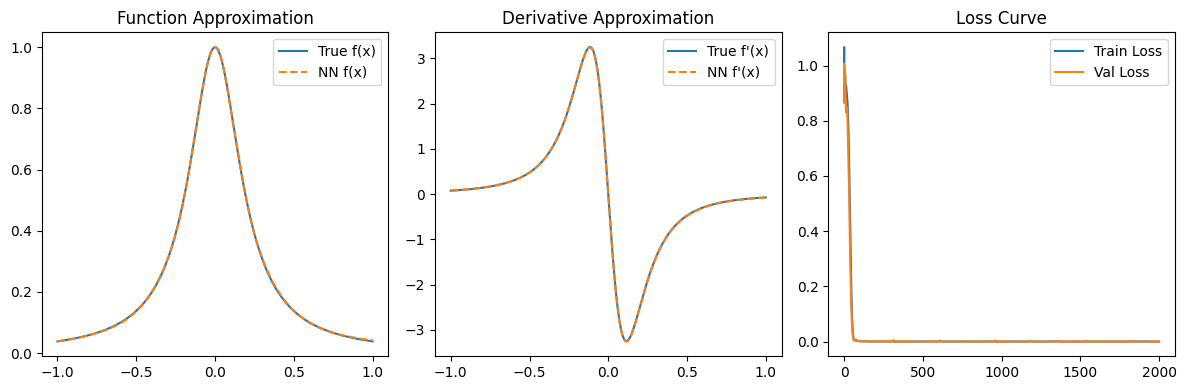

MSE f(x): 3.453976190979381e-06
MSE f'(x): 7.9594299526632e-05
Max error f(x): 0.005349384842098126
Max error f'(x): 0.03144921142724355


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ------------------------------
# 1. Define Runge function and derivative
# ------------------------------
def runge(x):
    return 1 / (1 + 25 * x**2)

def runge_derivative(x):
    return -50 * x / (1 + 25 * x**2)**2

# ------------------------------
# 2. Prepare dataset
# ------------------------------
# Sample training points
X = np.linspace(-1, 1, 200).reshape(-1, 1)
y_f = runge(X)
y_df = runge_derivative(X)
y = np.hstack([y_f, y_df])   # NN should output [f(x), f'(x)]

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# ------------------------------
# 3. Define Neural Network
# ------------------------------
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(1, 64)
        self.hidden2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, 2)   # 2 outputs: f(x), f'(x)

    def forward(self, x):
        x = torch.tanh(self.hidden1(x))
        x = torch.tanh(self.hidden2(x))
        return self.out(x)

model = Net()

# ------------------------------
# 4. Loss and optimizer
# ------------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# ------------------------------
# 5. Training loop
# ------------------------------
epochs = 2000
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch+1) % 200 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}")

# ------------------------------
# 6. Evaluation
# ------------------------------
X_test = np.linspace(-1, 1, 500).reshape(-1, 1)
y_test_f = runge(X_test)
y_test_df = runge_derivative(X_test)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()

pred_f = predictions[:, 0]
pred_df = predictions[:, 1]

# ------------------------------
# 7. Plot results
# ------------------------------
plt.figure(figsize=(12, 4))

# Plot f(x)
plt.subplot(1, 3, 1)
plt.plot(X_test, y_test_f, label="True f(x)")
plt.plot(X_test, pred_f, label="NN f(x)", linestyle="dashed")
plt.legend()
plt.title("Function Approximation")

# Plot f'(x)
plt.subplot(1, 3, 2)
plt.plot(X_test, y_test_df, label="True f'(x)")
plt.plot(X_test, pred_df, label="NN f'(x)", linestyle="dashed")
plt.legend()
plt.title("Derivative Approximation")

# Plot losses
plt.subplot(1, 3, 3)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.tight_layout()
plt.show()

# ------------------------------
# 8. Compute and report errors
# ------------------------------
mse_f = np.mean((y_test_f.flatten() - pred_f.flatten())**2)
mse_df = np.mean((y_test_df.flatten() - pred_df.flatten())**2)
max_err_f = np.max(np.abs(y_test_f.flatten() - pred_f.flatten()))
max_err_df = np.max(np.abs(y_test_df.flatten() - pred_df.flatten()))

print("MSE f(x):", mse_f)
print("MSE f'(x):", mse_df)
print("Max error f(x):", max_err_f)
print("Max error f'(x):", max_err_df)
